# A first complete session work: Adjusting a straight line

##### In this notebook we adjust the most basic example for a two parameter model: a stright line. What we are going to do is to fit the free parameters of it, i.e. we adjust $a$ and $b$ from our model $y=a+bx$.  
##### We generate 3 different set of data distributed randomly around a known straight line with a gaussian noise with different standar deviation $\sigma$ for each set of data. Two of the datasets are generated with the parameters $a=3$ and $b=2$ ($\sigma=0.1$ and $\sigma =0.2$) while the last dataset is generated with the parameters $a=3.5$ and $b=1.5$ ($\sigma = 0.15$). This is done in order to show the importance of the hyperparameter procedure.

In [1]:
'''We start with the packages that we will need in our procedure'''

%pylab inline

import pymc3 as pm
from pymc3.backends import SQLite
import triangle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/enriques/Downloads/yes/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### The procedure for our bayesian estimation is as follows:

##### 1.-We generate/download/import our data

##### 2.- We need to specify our model

##### 3.- With the help of PyMC we fit the best parameters that adjusted to our data.

##### 4.- If we have several datasets, we compare bout cases: with and without hyperparameters 

# We start generating our data

In [2]:
# Initialize random number generator
np.random.seed(123)

#True parameter values
a1_real = 3.
b1_real = 2.
sigma1 = 0.1
sigma2 = 0.2

a2_real = 3.5
b2_real = 1.5
sigma3 = 0.15
    
#Size of dataset
size = 16

#Generating our data

def stright(a,b,size,sigma):
    x = 3*np.random.randn(size)
    y = a+b*x+np.random.randn(size)*sigma
    return x, y

x1, y1 = stright(a1_real,b1_real,size,sigma1)
x2, y2 = stright(a1_real,b1_real,size,sigma2)
x3, y3 = stright(a2_real,b2_real,size,sigma3)

##### How our data looks like?

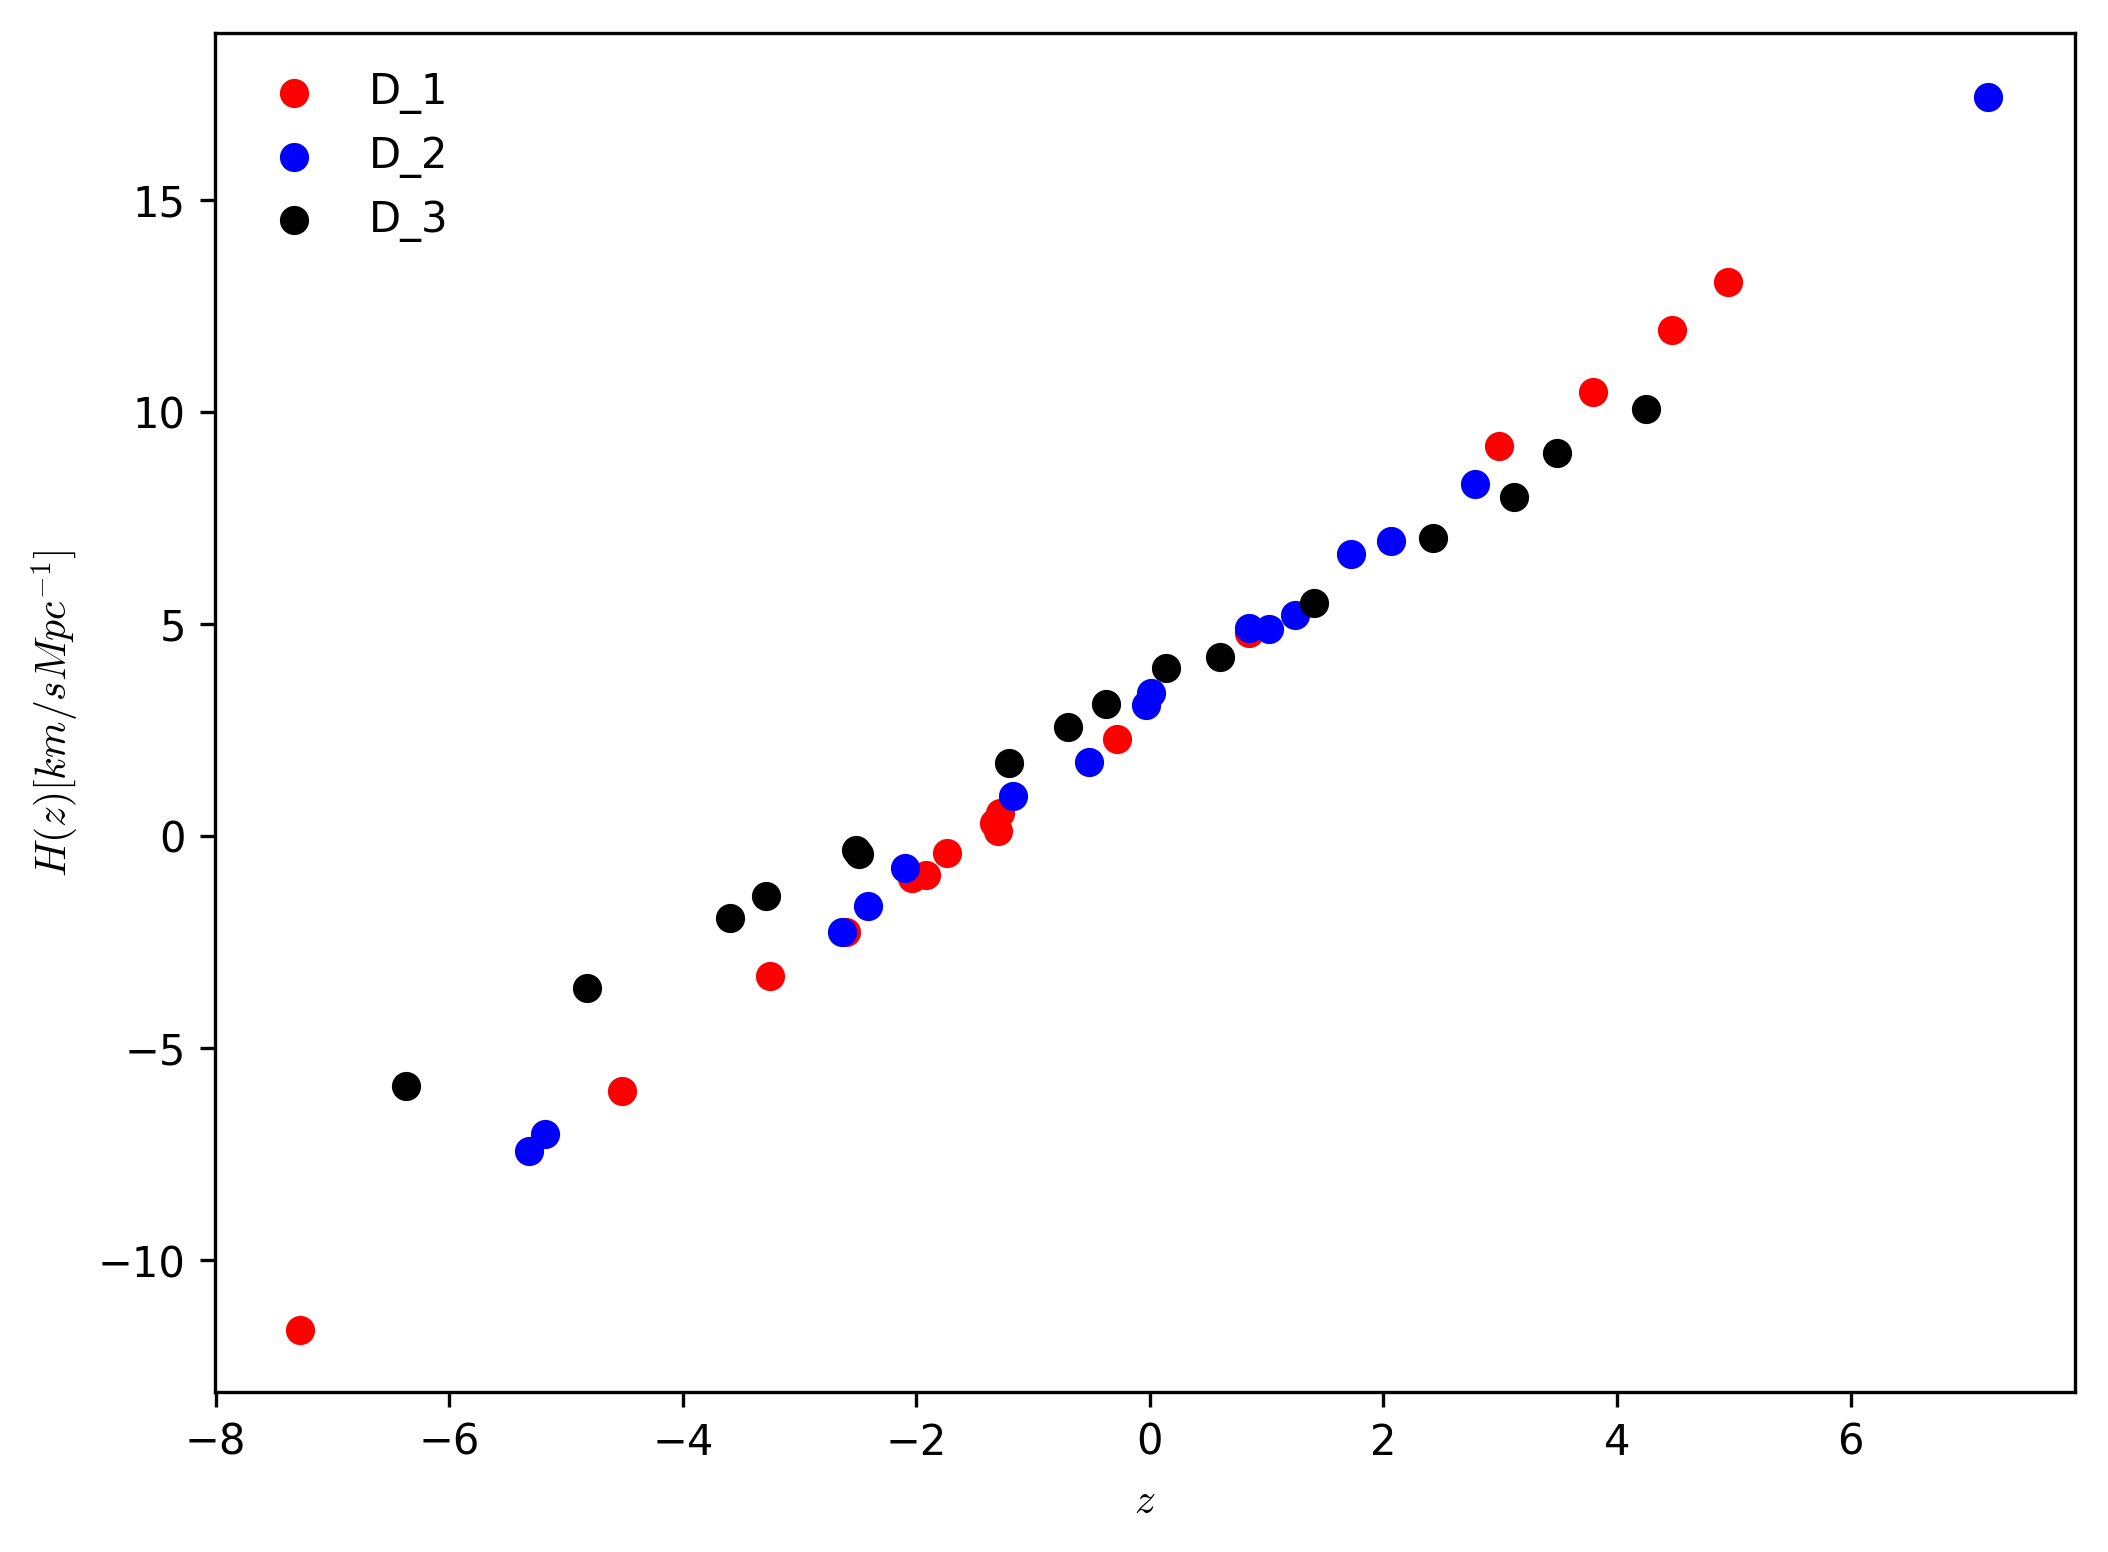

In [3]:
figsize = (8, 6)                        # definimos el tamaño de nuestra figura
dpi = 300                                # dots per inch

rcParams['font.size'] = 10            # establecemos el tamaño de la fuente
rcParams['lines.linewidth'] = 1          # el grosor de las líneas
rcParams['mathtext.fontset'] = 'cm'      # y el tipo de fuente en LaTex 

fig1 = figure(figsize=figsize, dpi=dpi)  # definimos la figura

 
plt.scatter(x1,y1,color="red",label = "D_1")
plt.scatter(x2,y2,color="blue",label = "D_2")
plt.scatter(x3,y3,color="black",label = "D_3")


plt.legend(loc='best', frameon=False)     #pon la legenda donde mejor quede sin marco

xlabel(r'$z$')                            
ylabel(r'$H(z) [km/s Mpc^{-1}]$')   

# Now it is time to specify our model. 

##### Suppose we are working in a theory where we would expect to have observations inside a stright line. Then we meassure our observables with 3 different mechanisms and we obtain the datasets shown before, $\langle D_1(a=3,b=2,\sigma=0.1),D_2(a=3,b=2,\sigma=0.2), D_3(a=3.5,b=0.15,\sigma=1.5)\rangle$. 0.

##### Given our theory we expect that all three data are part of the same theory, i.e. the same straight line, $y=a+bx$ (remember, at this point we consider that we don't know anything about the parameters of our model, $a$ and $b$). 

###### As we saw, we can analize our system in two different ways: first is by considering a typical bayesian estimation where our data is the complete data set. In the other side, we can make the same considering a weight for each dataset, this is, by taking into account a hyperparameter method. Lets see what happen.

## *Inference of parameters without hyperparameters

##### We need to consider priors for our parameters. In this example we consider a non-informative prior, i.e. we associate uniform distribution as our priors for our parameters. In the other side, we consider that the set of data are independent between them, in such case the complete Likelihood can be wirten as a product of the likelihoods associated with each data set. 

In [4]:
# Because we are interested in an inference without taking into account hyperparameters, it results the same if we
# consider the 3 datasets as one. It can be easily to see in the gaussian approximation. In this way we star adding all
# our data in one new vector called Data_x and Data_y

Data_x = np.concatenate((x1,x2,x3),axis = 0)
Data_y = np.concatenate((y1,y2,y3),axis = 0)

with pm.Model() as model0:
    # Priors for unknown model parameters
    a0 = pm.Uniform('a0', lower=-5, upper=5)
    b0 = pm.Uniform('b0', lower=0, upper=4)
    sigma0 = pm.Uniform('sigma0', lower = 0, upper = 1.5)
    
    y0 = a0+b0*Data_x
    
    Lik0 = pm.Normal('Lik0',mu=y0,sd=sigma0,observed=Data_y)   

In [5]:
#We specify the number of iterations
niter0=10000
with model0:
    start0 = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step0 = pm.Metropolis()
    db0 = SQLite('H0_3_Data.db')
    trace0 = pm.sample(niter0, trace=db0, step=step0, start=start0, njobs=6, temp = 2, thin=20, cores=4,random_seed=123)

logp = -62.08, ||grad|| = 0.50362: 100%|██████████| 16/16 [00:00<00:00, 63.77it/s]  
Multiprocess sampling (6 chains in 6 jobs)
CompoundStep
>Metropolis: [sigma0_interval__]
>Metropolis: [b0_interval__]
>Metropolis: [a0_interval__]
  0%|          | 0/10500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 34%|███▍      | 3605/10500 [00:06<00:12, 571.92it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 67%|██████▋   | 7059/10500 [00:14<0

In [6]:
start0

{'a0': array(3.23518519),
 'a0_interval__': array(1.54037009),
 'b0': array(1.83118981),
 'b0_interval__': array(-0.1692128),
 'sigma0': array(0.80984217),
 'sigma0_interval__': array(0.15991907)}

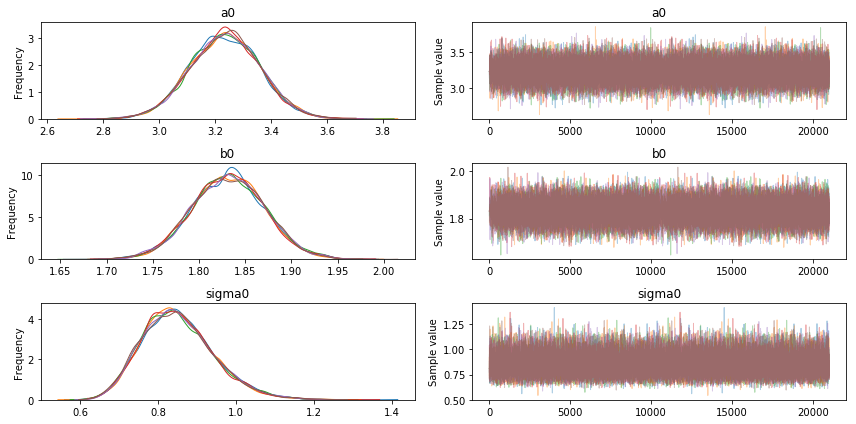

In [7]:
with model0:
    tracee = pm.backends.sqlite.load('H0_3_Data.db')
    pm.traceplot(tracee, varnames=['a0','b0','sigma0'])

In [8]:
t0 = trace0[niter0//2:]
t0['a0'].shape
t0['b0'].shape
t0['sigma0'].shape

(90000,)

In [9]:
a0 = trace0.get_values('a0', burn=niter0//2, combine=True, chains=[0,2])
a0.shape

b0 = trace0.get_values('b0', burn=niter0//2, combine=True, chains=[0,2])
b0.shape

sigma0 = trace0.get_values('sigma0', burn=niter0//2, combine=True, chains=[0,2])
sigma0.shape

(30000,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xc6c8690>,
      dtype=object)

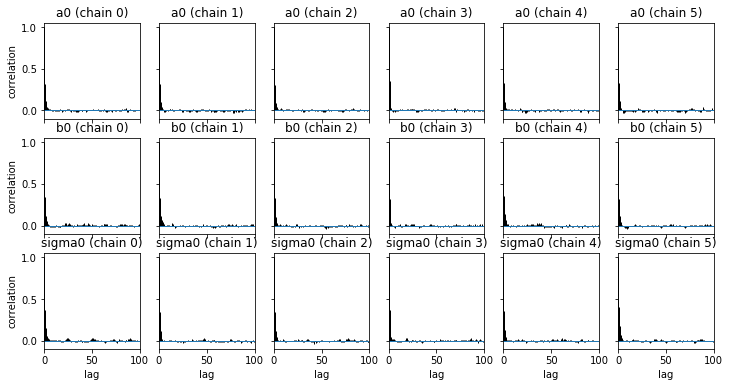

In [10]:
pm.autocorrplot(t0, varnames=['a0','b0','sigma0'])

In [11]:
pm.effective_n(t0)

{'a0': 45760.0, 'b0': 44153.0, 'sigma0': 41543.0}

In [12]:
pm.gelman_rubin(t0)

{'a0': 1.0001659752897836,
 'b0': 1.0000645963547576,
 'sigma0': 1.000141159177405}

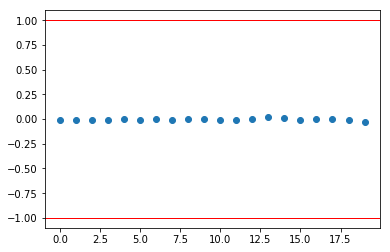

In [13]:
plt.plot(pm.geweke(t0['a0'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)

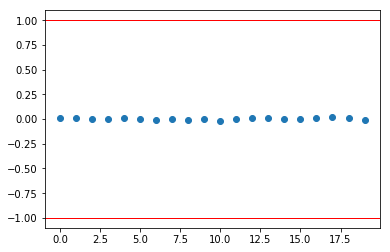

In [14]:
plt.plot(pm.geweke(t0['b0'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)

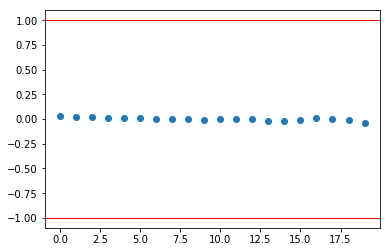

In [15]:
plt.plot(pm.geweke(t0['sigma0'])[:,1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)

In [16]:
pm.summary(t0, varnames=['a0','b0','sigma0'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,3.235488,0.125256,0.000591,2.988784,3.481269,45760.0,1.000166
b0,1.831292,0.039822,0.000181,1.753103,1.908542,44153.0,1.000065
sigma0,0.850699,0.092505,0.000491,0.683804,1.038255,41543.0,1.000141


/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


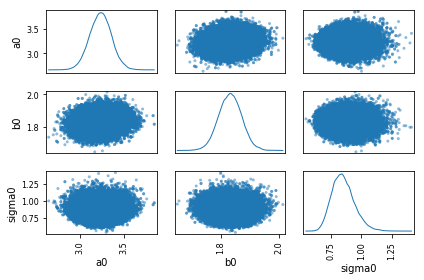

In [17]:
df_trace0 = pm.trace_to_dataframe(trace0[niter0//2:])
pd.scatter_matrix(df_trace0.ix[-niter0//2:, ['a0', 'b0','sigma0']], diagonal='kde')
plt.tight_layout()
plt.show()

/home/enriques/Downloads/yes/lib/python2.7/site-packages/matplotlib/contour.py:920: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


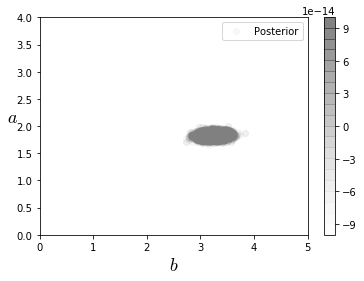

In [18]:
plot(a0, b0,
     linestyle='none', marker='o', color='grey', mec='grey',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a0, b0])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,20, linewidths=1, alpha=.5, cmap='Greys')
plt.colorbar();

ylabel(r'$a$', fontsize=18, rotation=0)
xlabel(r'$b$', fontsize=18)
legend()
axis([0., 5., 0., 4.])
savefig('param_dist.png')

### Extra example: Fitting the model with MC^3

##### In this section we are giong to do the same, but not considering the MC^3 method.

## *Inference of parameters with hyperparameters


##### Now it is time to fit our model using the hyperparameters method. In this example we will use the same prior but considering the Likelihood given in eq: (43) of the paper [ref].

In [5]:
import theano.tensor as T
import theano as TT

def ymodel(a,b,x):
    return a+b*x
    
def chi2(a,b,x,data,sigma2,n):
    D = ymodel(a,b,x)-data
    sigma2_mat_inv = T.nlinalg.AllocDiag()((1/sigma2)*T.ones(n))
    return T.dot(D,T.dot(sigma2_mat_inv,D))/2

def log_Like1D(a,b,x,y,sigma2,n):
    N = 1*n/2+1.
    extr = 2/(math.pi**(n/2)*sigma2**(size/2))
    return T.gammaln(N)-N*T.log(chi2(a,b,x,y,sigma2,n)+2)+T.log(extr)

with pm.Model() as model1:
    # Priors for unknown model parameters
    a = pm.Uniform('a', lower=-5., upper=8.)
    b = pm.Uniform('b', lower=0., upper=4.)
    sigma2 = pm.Uniform('sigma', lower = 0.0001, upper = 3.)
   
    Lik = pm.Potential('Lik',log_Like1D(a,b,x1,y1,sigma2,size)+log_Like1D(a,b,x2,y2,sigma2,size)+log_Like1D(a,b,x3,y3,sigma2,size))

In [91]:
niter=10000
with model1:
    start = pm.find_MAP() #Compute a maximum a posteriori estimates 
    step = pm.Metropolis()
    db = SQLite('MH1prove3Data.db')
    trace = pm.sample(niter, trace=db, step=step, start=start,njobs=5,temp = 2,thin=20,cores = 4, random_seed=123)

logp = -17.161, ||grad|| = 24.501: 100%|██████████| 27/27 [00:00<00:00, 116.75it/s] 
Multiprocess sampling (5 chains in 5 jobs)
CompoundStep
>Metropolis: [sigma_interval__]
>Metropolis: [b_interval__]
>Metropolis: [a_interval__]
  0%|          | 0/5500 [00:00<?, ?it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
 65%|██████▌   | 3596/5500 [00:06<00:03, 520.12it/s]/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/backends/sqlite.py:121: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.var_dtypes[varname], np.int):
100%|██████████| 5500/5500 [00:12<00:00, 

In [92]:
start

{'a': array(3.03788017),
 'a_interval__': array(0.48233235),
 'b': array(1.99335901),
 'b_interval__': array(-0.00664102),
 'sigma': array(0.02398101),
 'sigma_interval__': array(-4.82525824)}

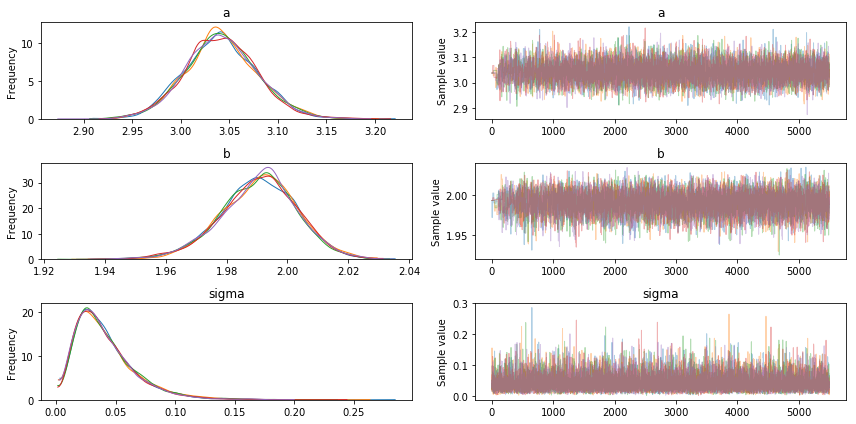

In [93]:
with model1:
    tracee = pm.backends.sqlite.load('MH1prove3Data.db')
    pm.traceplot(tracee, varnames=['a','b','sigma'])

In [97]:
t = trace[niter//2:]
t['a'].shape
t['b'].shape
t['sigma'].shape

(12500,)

In [98]:
a = trace.get_values('a', burn=niter//2, combine=True, chains=[0,2])
a.shape

b = trace.get_values('b', burn=niter//2, combine=True, chains=[0,2])
b.shape

sigma = trace.get_values('sigma', burn=niter//2, combine=True, chains=[0,2])
sigma.shape

(5000,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c9b5450>,
      dtype=object)

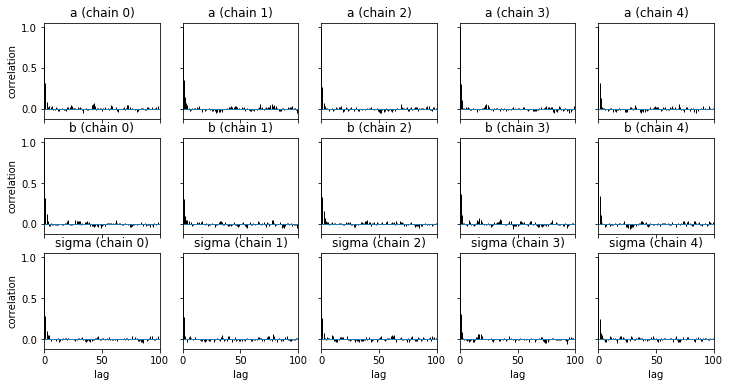

In [99]:
pm.autocorrplot(t, varnames=['a','b','sigma'])

In [100]:
pm.effective_n(t)

{'a': 6386.0, 'b': 6244.0, 'sigma': 7157.0}

In [101]:
pm.gelman_rubin(t)

{'a': 1.000042445682013, 'b': 1.0003319606701087, 'sigma': 1.000409746120667}

In [102]:
pm.summary(t, varnames=['a','b','sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,3.041687,0.037204,0.000467,2.970533,3.116639,6386.0,1.000042
b,1.990496,0.012892,0.000171,1.965305,2.016450,6244.0,1.000332
sigma,0.041346,0.025221,0.000284,0.004925,0.089790,7157.0,1.000410


/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
/home/enriques/Downloads/yes/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  from ipykernel import kernelapp as app


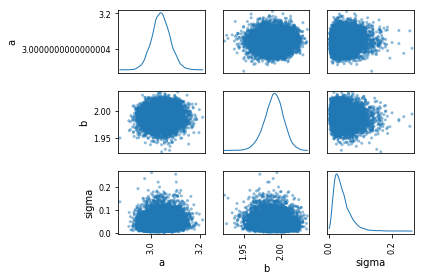

In [103]:
df_trace = pm.trace_to_dataframe(tracee[niter//2:])
pd.scatter_matrix(df_trace.ix[-niter//2:, ['a', 'b','sigma']], diagonal='kde')
plt.tight_layout()
plt.show()

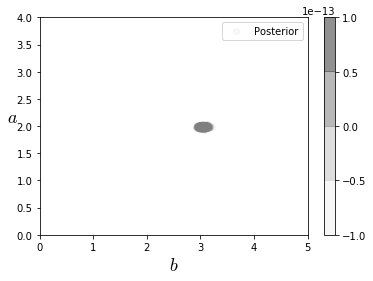

In [104]:
plot(a, b,
     linestyle='none', marker='o', color='grey', mec='grey',
alpha=.05, label='Posterior', zorder=-100)

import scipy.stats
gkde = scipy.stats.gaussian_kde([a, b])
x,y = mgrid[0.:1.:5., 0.:100.:4.]
z = array(gkde.evaluate([x.flatten(),y.flatten()])).reshape(x.shape)
contourf(x, y, z,3, linewidths=1, alpha=.5, cmap='Greys')
plt.colorbar();

ylabel(r'$a$', fontsize=18, rotation=0)
xlabel(r'$b$', fontsize=18)
legend()
axis([0., 5., 0., 4.])
savefig('param_dist.png')

# But, what method is better?

##### PyMC contains a way to estimate the Bayes factor using the Sequential Monte Carlo method. So, let us recalculate our posterior using this method

In [6]:
#We specify the number of iterations
from tempfile import mkdtemp
from pymc3.step_methods import smc 
niter0=25000
folder = mkdtemp(prefix='strightline')
with model0:
    trace0_nm = smc.sample_smc(niter0,n_chains = 5,homepath = folder,progressbar=False,stage = 0,random_seed=123)
    
with model1:
    trace1_nm = smc.sample_smc(niter0,n_chains = 5,homepath = folder,progressbar=False,stage = 0,random_seed=123)

/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/step_methods/smc.py:491: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Argument `step` is None. Auto-initialising step object using given/default parameters.
/home/enriques/Downloads/yes/lib/python2.7/site-packages/pymc3/step_methods/smc.py:119: UserWarning: Warning: SMC is an experimental step method, and not yet recommended for use in PyMC3!
  warnings.warn(EXPERIMENTAL_WARNING)
Adding model likelihood to RVs!
Init new trace!
Sample initial stage: ...
Beta: 0.000000 Stage: 0
Initialising chain traces ...
Sampling ...
Beta: 0.003409 Stage: 1
Initialising chain traces ...
Sampling ...
Beta: 0.027116 Stage: 2
Initialising chain traces ...
Sampling ...
Beta: 0.062647 Stage: 3
Initialising chain traces ...
Sampling ...
Beta: 0.097559 Stage: 4
Initialising chain traces ...
Sampling ...
Beta: 0.174855 Stage: 5
Initialising chain traces ..

In [7]:
#Computing the Bayes factor
BF = model1.marginal_likelihood / model0.marginal_likelihood
print(round(BF))

23.0
